# SST Experimental Prediction with LSTM and CNN - HCMR/IO 

# 1. Retrieve data file 

In [ ]:
# File sharing link from Google Drive: https://drive.google.com/file/d/1bzBtzGe80qVpRhUxFiBwKI2ouSu9bmxT/view?usp=share_link
!gdown 1bzBtzGe80qVpRhUxFiBwKI2ouSu9bmxT

Downloading...
From: https://drive.google.com/uc?id=1bzBtzGe80qVpRhUxFiBwKI2ouSu9bmxT
To: /home/posuser/AI/Konstantinos/2) Κώδικας LSTM/New-LSTM-CNN3-CNN12/cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.nc
100%|██████████████████████████████████████| 95.5k/95.5k [00:00<00:00, 1.31MB/s]


# 2. Read data

In [2]:
# Read NetCDF
import xarray as xr
import pandas as pd

ds = xr.open_dataset('./cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.nc')
df = ds.to_dataframe().reset_index()
df.to_csv('cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.csv', index = False)
df.columns

Index(['time', 'lat', 'lon', 'analysed_sst'], dtype='object')

In [3]:
# Read CSV
df = pd.read_csv('cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.csv', header=0, parse_dates=['time'], index_col=['time'])

# Convert Kelvin to Celsius
df["celsius"] = df['analysed_sst'] - 273.15

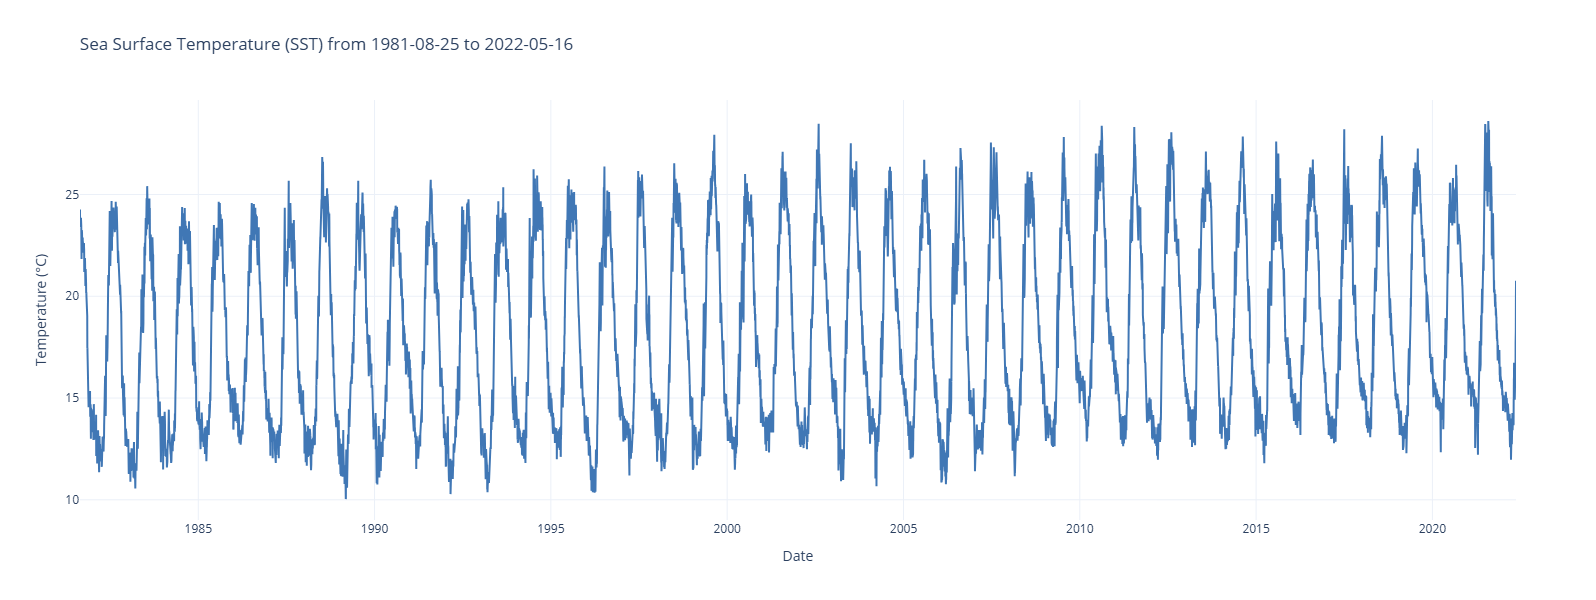

In [4]:
# Print timeseries
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x=df.index ,y=df['celsius'], line=dict(color='rgb(64, 119, 181)')))

fig.update_layout(
    autosize=True,
    height=600,
    title="Sea Surface Temperature (SST) from "+str(df.index.date.min())+" to "+str(df.index.date.max())+"",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    template='plotly_white'
)

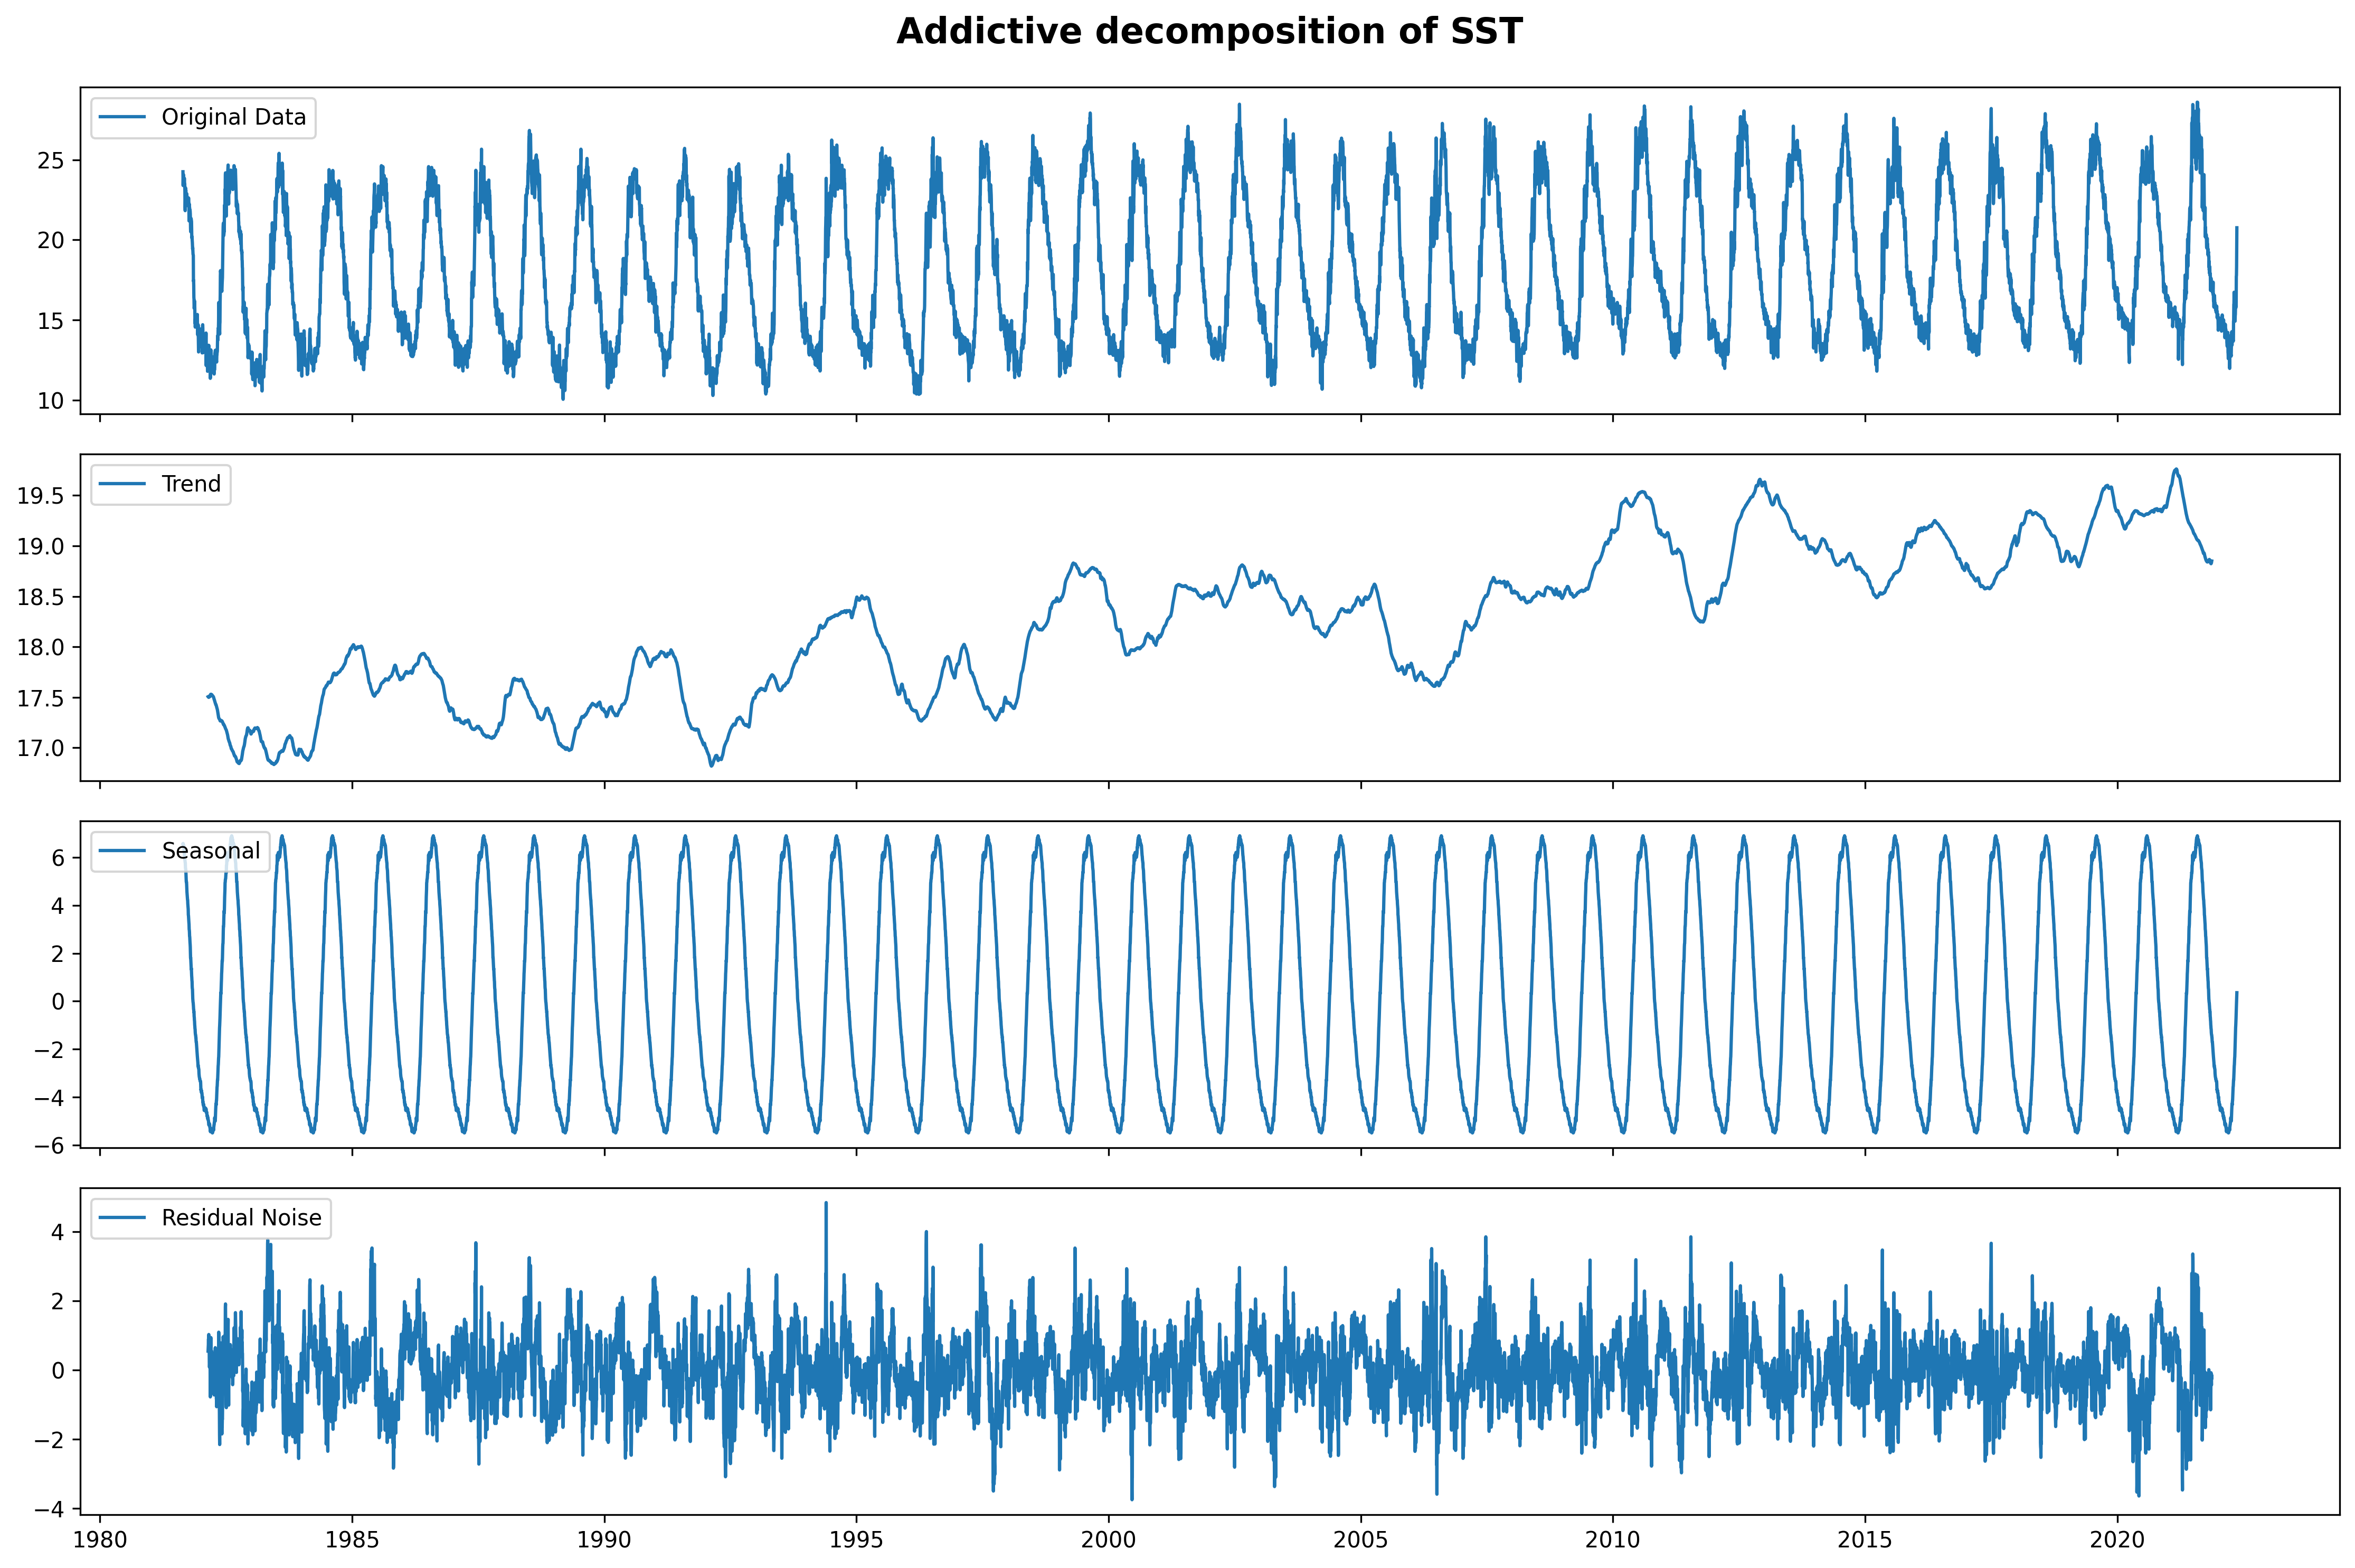

In [5]:
# Print timeseries decomposition, trend, residuals etc.
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = 15, 10
rcParams['figure.dpi'] = 300

decomp = seasonal_decompose(df["celsius"], model='additive', period=365)
printing_results = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]
labels = ['Original Data','Trend','Seasonal','Residual Noise']
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=False)
axes[0].set_title("Addictive decomposition of SST", fontweight='bold', fontsize=16, pad=20)
for i, ax in enumerate(axes):
  axes[i].plot(printing_results[i],label=labels[i])
  axes[i].legend(loc="upper left")

plt.tight_layout()
plt.show()

# 3. Data preprocessing

## 3.1 Exploratory analysis of data

In [6]:
# Missing values check
df.isnull().sum()

lat             0
lon             0
analysed_sst    0
celsius         0
dtype: int64

In [7]:
# NAN values check
df.isna().sum()

lat             0
lon             0
analysed_sst    0
celsius         0
dtype: int64

In [8]:
# Print number of dates of our dataset
len(pd.date_range(start=df.index.min(), end=df.index.max(), freq='D'))

14875

In [9]:
# Summary statistics of SST
df.celsius.describe()

count    14875.000000
mean        18.204773
std          4.516205
min         10.040000
25%         14.090000
50%         17.269980
75%         22.540000
max         28.609980
Name: celsius, dtype: float64

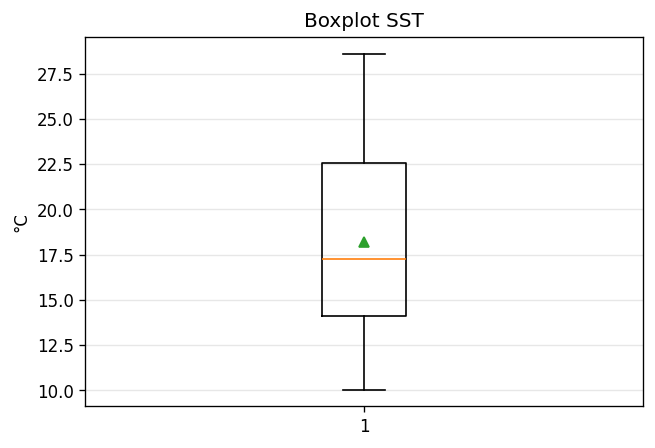

In [10]:
# Boxplot for extreme values check
plt.figure(figsize=(6,4), dpi=120)
plt.boxplot(df["celsius"], vert=True, showmeans=True)
plt.title("Boxplot SST")
plt.ylabel("°C")
plt.grid(axis="y", alpha=0.3)
plt.show()

(array([ 408., 2684., 2799., 1687., 1228., 1331., 1539., 2003., 1006.,
         190.]),
 array([10.04    , 11.896998, 13.753996, 15.610994, 17.467992, 19.32499 ,
        21.181988, 23.038986, 24.895984, 26.752982, 28.60998 ]),
 <BarContainer object of 10 artists>)

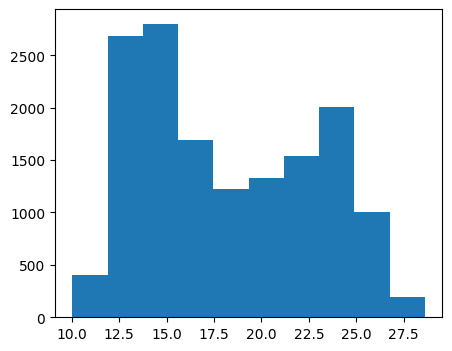

In [ ]:
# Histplot for distribution check
plt.figure(figsize=(5,4), dpi=100)
plt.hist(df.celsius)

## 3.2 Split of data in three parts (70% for training, 15% for validation, 15% for testing)

In [ ]:
# Print days used per pipeline phase 
df_initial = df.copy()
df = df['celsius'].to_frame()

total = len(df.index) 
calc_15_percent = int(round(total * 0.15)) 
calc_75_percent = int(round(total * 0.75)) 
print (f'Total data = {total} days')
print (f'75% of data = {calc_75_percent} days')
print (f'15% of data= {calc_15_percent} days')

Total data = 14875 days
75% of data = 11156 days
15% of data= 2231 days


In [13]:
# Split train and test data (trainning and testing)
# The test_size parameter is the percentage of the test data, while the shuffle parameter is the random distribution of the data before the splitting
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=calc_15_percent, shuffle=False)
print(f'Trainning data = {len(train_data)} days \nTesting data = {len(test_data)} days')

Trainning data = 12644 days 
Testing data = 2231 days


In [14]:
# Split train and test data (trainning-validation and testing)
train_data, validation_data = train_test_split(train_data, test_size=len(test_data), shuffle=False)
print(f'Trainning data = {len(train_data)} days \nValidation data = {len(validation_data)} days')

Trainning data = 10413 days 
Validation data = 2231 days


### 3.2.1 Visualize the data split

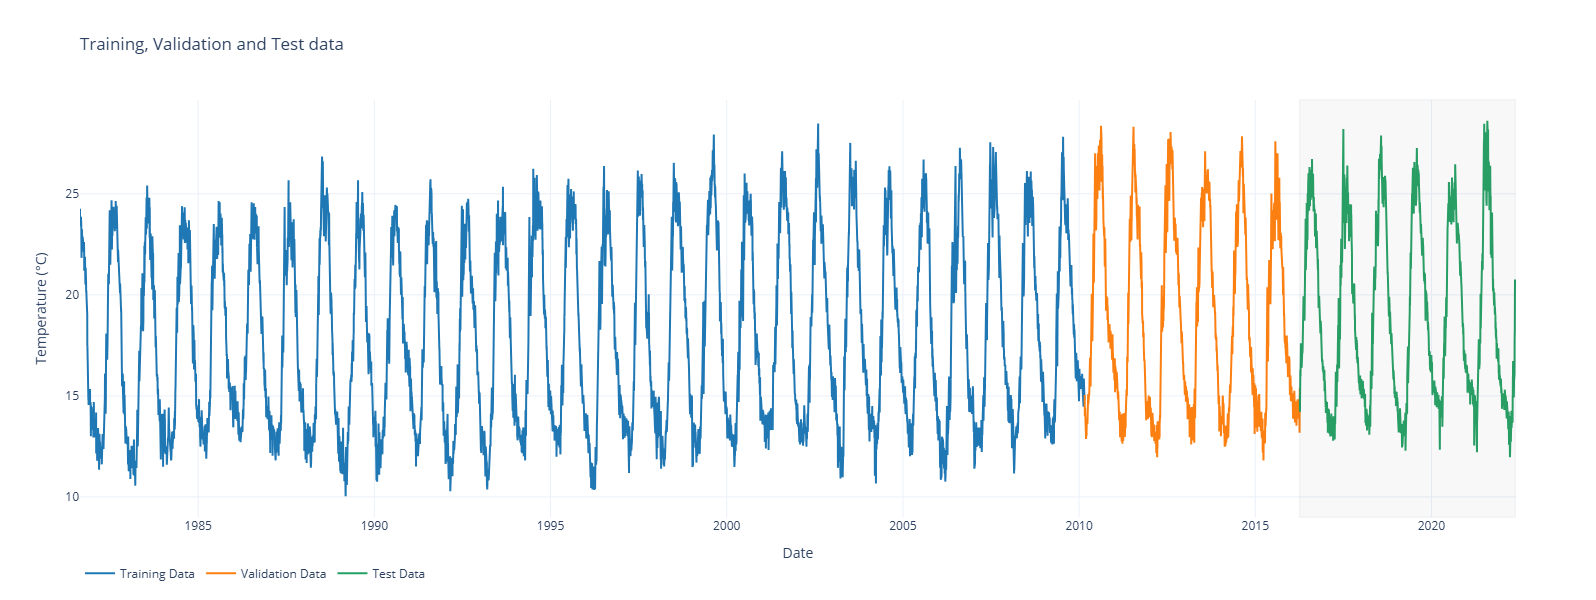

In [ ]:
# Visualize the trainning data, validation and testing data in the timeseries
df_splitted_all = pd.DataFrame(columns=['train','validation','test'], index=df.index) 
df_splitted_all['train']= train_data
df_splitted_all['validation']= validation_data
df_splitted_all['test']= test_data

fig = go.Figure()
fig.add_vrect(x0=test_data.index[0], x1=test_data.index[-1], fillcolor="gray", opacity=0.05)
fig.add_trace(go.Scatter(mode='lines', x=df_splitted_all.index, y=df_splitted_all['train'], line=dict(color="rgb(31,119,180)"), name='Training Data'))
fig.add_trace(go.Scatter(mode='lines', x=df_splitted_all.index, y=df_splitted_all['validation'], line=dict(color="rgb(251,127,17)"), name='Validation Data'))
fig.add_trace(go.Scatter(mode='lines', x=df_splitted_all.index, y=df_splitted_all['test'], line=dict(color="rgb(35,160,100)"), name='Test Data'))

fig.update_layout(
    legend=dict(
    orientation="h"),
    autosize=True,
    # width=800,
    height=600,
    title="Training, Validation and Test data", #for "+str(df.index.year.min())+" - "+str(df.index.year.max()),
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    template='plotly_white'
)

In [16]:
# Print the dates of each sub-dataset
print(f'''Trainning data: {train_data.index.date.min()} to {train_data.index.date.max()}
Validation data: {validation_data.index.date.min()} to {validation_data.index.date.max()}
Testing data: {test_data.index.date.min()} to {test_data.index.date.max()}''')

Trainning data: 1981-08-25 to 2010-02-26
Validation data: 2010-02-27 to 2016-04-06
Testing data: 2016-04-07 to 2022-05-16


## 3.3 Normalization of the Data

In [ ]:
# Implement normalization
from sklearn.preprocessing import MinMaxScaler

data_scaler = MinMaxScaler() # default normalization (0,1)
data_scaler.fit_transform((df['celsius'].values).reshape(-1, 1)) # use 2D transformation by reshape(-1, 1) function

train_data_scaled = data_scaler.transform(train_data.values)
validation_data_scaled = data_scaler.transform(validation_data.values)
test_data_scaled = data_scaler.transform(test_data.values)
print("Data shapes:",
      "\nTrain", train_data_scaled.shape,
      "\nValidation", validation_data_scaled.shape,
      "\nTest", test_data_scaled.shape, "\n")
print("Example of normalized data in the validation set:\n", test_data_scaled)

Data shapes: 
Train (10413, 1) 
Validation (2231, 1) 
Test (2231, 1) 

Example of normalized data in the validation set:
 [[0.26655818]
 [0.22509448]
 [0.31664008]
 ...
 [0.44588093]
 [0.52504095]
 [0.5772758 ]]


### 3.3.1 Make batches

In [18]:
# Import libraries and define window time and batches in each set
import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
window_lag_days = 12 # Number of days included to have one output 

batches_for_Train_Data = TimeseriesGenerator(train_data_scaled, # normalized timeseries values
                                             train_data_scaled, # goal (same length with the timeseries)
                                             stride=1, # time step between instances
                                             length=window_lag_days, # window frame time (for prediction)
                                             batch_size=1 # number of tranning data per batch
                                             )

batches_for_Validation_Data = TimeseriesGenerator(validation_data_scaled,
                                                 validation_data_scaled,
                                                 stride=1,
                                                 length=window_lag_days,
                                                 batch_size=1
                                                 )

batches_for_Test_Data = TimeseriesGenerator(test_data_scaled,
                                           test_data_scaled,
                                           stride=1,
                                           length=window_lag_days,
                                           batch_size=1
                                           )

# Example of one batch of tranning data
X,y = batches_for_Train_Data[0]
print(f'Sequence of {window_lag_days} values (Χ): \n{X.flatten()}')
print(f'Goal to predict (y): \n {y.flatten()}')

2025-12-26 19:02:33.771253: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-26 19:02:33.795775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sequence of 12 values (Χ): 
[0.76575204 0.71944073 0.74205788 0.74421082 0.7560579  0.7452889
 0.73290332 0.73774878 0.73398033 0.73398033 0.74421082 0.73505733]
Goal to predict (y): 
 [0.72482577]


2025-12-26 19:02:34.347030: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### 3.3.2 Define normalized batch results

In [19]:
# Function to create all inputs and it's relevant outputs in different tables
import numpy as np

def get_all_scaled_data(generated_batches):
  data_X_scaled = []
  data_y_scaled = []
  for i in range(len(generated_batches)):
    x, y = generated_batches[i]
    data_X_scaled.append(x.flatten())
    data_y_scaled.append(y.flatten())

  return np.array(data_X_scaled), np.array(data_y_scaled)

# Implement the above to get the array of X and it's corresponding y in the trainning data
train_X_scaled, train_y_scaled = get_all_scaled_data(batches_for_Train_Data)

# Implement the above to get the array of X and it's corresponding y in the validation data
validation_X_scaled, validation_y_scaled = get_all_scaled_data(batches_for_Validation_Data)

# Implement the above to get the array of X and it's corresponding y in the testing data
test_X_scaled, test_y_scaled = get_all_scaled_data(batches_for_Test_Data)

### 3.3.3 Save normalized batch results

In [ ]:
# Function to save the previous tables in a CSV file
def save_to_csv(data, X, y, scaled_or_normal='scaled_train_data', print='no', real=''):
  df_csv = pd.DataFrame()
  df_csv = pd.DataFrame(X, columns=['X'+str(i) for i in range(1, window_lag_days+1)], index=data.index[window_lag_days:]) 
  df_csv["TARGET"] = y
  if real == 'real':
    for i in range(horizon):
      df_csv["REAL"+str(i+1)] = data[window_lag_days:].shift(-i)

  df_csv.to_csv(scaled_or_normal+'.csv')
  if print == 'yes':
    return df_csv

# CSV export of tranning data with normalized values
#save_to_csv(train_data, train_X_scaled, train_y_scaled, 'scaled_train_data')

# CSV export of tranning data with Celcius values
normal_X_train = data_scaler.inverse_transform(train_X_scaled)
normal_y_train = data_scaler.inverse_transform(train_y_scaled)
#save_to_csv(train_data, normal_X_train, normal_y_train, 'normal_train_data')


# CSV export of validation data with normalized values
#save_to_csv(validation_data, validation_X_scaled, validation_y_scaled, 'scaled_validation_data')

#CSV export of validation data with Celcius values
normal_X_validation = data_scaler.inverse_transform(validation_X_scaled)
normal_y_validation = data_scaler.inverse_transform(validation_y_scaled)
#save_to_csv(validation_data, normal_X_validation, normal_y_validation, 'normal_validation_data')


# CSV export of testing data with normalized values
save_to_csv(test_data, test_X_scaled, test_y_scaled, 'scaled_test_data')

# CSV export of testing data with Celcius values
normal_X_test = data_scaler.inverse_transform(test_X_scaled)
normal_y_test = data_scaler.inverse_transform(test_y_scaled)
#save_to_csv(test_data, normal_X_test, normal_y_test, 'normal_test_data')

 #### 3.3.3.1 Save batches with targets

In [ ]:
# CSV export of batches (each batch contains 12 days and it's predictor outcome) with Celcius values
all_train = pd.concat([train_data,validation_data[:-12]]) 
all_train_X = np.concatenate((train_X_scaled,validation_X_scaled)) 
all_train_y = np.concatenate((train_y_scaled,validation_y_scaled)) 
normal_all_train_X = data_scaler.inverse_transform(all_train_X)
normal_all_train_y = data_scaler.inverse_transform(all_train_y)
#save_to_csv(all_train, normal_all_train_X, normal_all_train_y, 'normal_all_train')

# 4. LSTM implementation for SST prediction

## 4.1 Definition of hyperparameters 

In [22]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras import metrics
!pip install -q -U keras-tuner

horizon=1 # Number of days for output
n_features=1 # Number of variables used for prediction

In [ ]:
# LSTM model creation 
# This, as well as CNN3 and CNN12 trainnings and model definitions can be skipped to the load of the models eg 4.2.4 for LSTM
def model_builder(hp):
  model = keras.Sequential()
  model.add(LSTM(units=hp.Int('units', min_value=10, max_value=200, step=2), 
                 activation='relu',
                 #input_shape (batch_size, time_steps, input_dimension/num_features)
                 #batch_size = None(any size), in TimeseriesGenerator was defined as 1
                 input_shape=(window_lag_days, n_features)
                ))
  model.add(Dense(horizon))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',values=[1e-4, 1e-3])),
                loss= 'mean_squared_error',
                metrics=[metrics.RootMeanSquaredError(name="rmse")]
                )
  return model

In [24]:
# Define Hyperband as the search algorithm
tuner = kt.Hyperband(model_builder,
                     objective= kt.Objective("val_rmse", direction="min"),
                     max_epochs=200,
                     factor=3,
                     directory='Hyperband-searches',
                     project_name='Hyperband_units-rate'
                     )

tuner.search_space_summary(extended=True)
stop_early = EarlyStopping(monitor='val_rmse', patience=20, verbose=1) # Early stop of search if the 20 upcoming seasons do not show a better result in RMSE in the validation data

# LSTM hyperparameter search implementation
tuner.search(batches_for_Train_Data,
             epochs=200,
             shuffle=True,
             validation_data=batches_for_Validation_Data,
             callbacks=[stop_early])

Reloading Tuner from Hyperband-searches/Hyperband_units-rate/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 2, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001], 'ordered': True}


In [ ]:
# Retrieve best hyperparameters for LSTM
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The search is complete, the optimized number of nodes to the LSTM is {best_hps.get('units')}
and the optimized learning rate for the optimizer is {best_hps.get('learning_rate')}
""")


The search is complete, the optimized number of nodes to the LSTM is 164
and the optimized learning rate for the optimizer is 0.0001



## 4.2 Definition of LSTM

In [ ]:
# Creation of the LSTM
from keras.models import Sequential

hypermodel_LSTM = Sequential() 
hypermodel_LSTM.add(LSTM(190, activation='relu', input_shape=(window_lag_days, n_features))) 
hypermodel_LSTM.add(Dense(horizon))
hypermodel_LSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                        loss= 'mean_squared_error',
                        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

# Save of the architecture of the model in JSON file
with open("hypermodel_LSTM_fit.json", "w") as m:
    m.write(hypermodel_LSTM.to_json())

I0000 00:00:1766768703.897339 1934138 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1077 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/posuser/anaconda3/envs/poseidon_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [27]:
# Plot of the LSTM
from keras.utils import plot_model

plot_model(hypermodel_LSTM,
           #to_file='model.png',
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='LR',
           expand_nested=True,
           dpi=150,
           layer_range=None,
           show_layer_activations=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### 4.2.1 Trainning of LSTM

In [ ]:
# ModelCheckpoint saves the best weights of the model
from keras.callbacks import ModelCheckpoint 

Model_Checkpoint = ModelCheckpoint(filepath='LSTM/hypermodel_LSTM.weights.h5', 
                                   monitor= 'val_rmse',
                                   save_weights_only=True,
                                   verbose=1, save_best_only=True)

stop_early = EarlyStopping(monitor='val_rmse', patience=50, verbose=1) # Early stop of search if the 50 upcoming seasons do not show a better result in RMSE in the validation data

# Trainning and save of the history 
history_hypermodel_Trainning = hypermodel_LSTM.fit(batches_for_Train_Data,
                                                   epochs=300,
                                                   verbose=1,
                                                   callbacks=[Model_Checkpoint, stop_early],
                                                   shuffle=True, 
                                                   validation_data=(batches_for_Validation_Data))

Epoch 1/300


2025-12-26 19:06:04.331804: I external/local_xla/xla/service/service.cc:163] XLA service 0x750f580148b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-26 19:06:04.331817: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-12-26 19:06:04.350227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-26 19:06:04.438582: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


   73/10401 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.1568 - rmse: 0.3930

I0000 00:00:1766768764.672328 1935200 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10370/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - rmse: 0.0841
Epoch 1: val_rmse improved from None to 0.04028, saving model to LSTM/hypermodel_LSTM.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0030 - rmse: 0.0551 - val_loss: 0.0016 - val_rmse: 0.0403
Epoch 2/300
10375/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 2: val_rmse improved from 0.04028 to 0.03105, saving model to LSTM/hypermodel_LSTM.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 9.6408e-04 - val_rmse: 0.0310
Epoch 3/300
10356/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - rmse: 0.0326
Epoch 3: val_rmse improved from 0.03105 to 0.03065, saving model to LSTM/hypermodel_LSTM.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 9.8393e-04 - rmse: 0.0314 - val_loss: 9.3973e-04 - val_rmse: 0.0307
Epoch 4/300
10400/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7757e-04 - rmse: 0.0296
Epoch 4: 

For weights only: Use .weights.h5 as the file extension.
For saving the full model (architecture + weights), you can use .keras.
```
# Saves both architecture and weights
model.save('LSTM/my_full_model.keras')  

# Save weights only using Keras format
model.save('LSTM/hypermodel_LSTM_weights.keras', save_format='keras') #maybe .weights.h5
# Save the model weights using model.save() directly in the .keras format
model.save('LSTM/hypermodel_LSTM_weights.keras', save_weights_only=True)

# Manually save weights after training
model.save_weights('LSTM/hypermodel_LSTM_weights.keras', save_format='keras')
```

Loading the Weights:
If you need to load the weights later, you'll still need to load the model architecture first (either define it manually or load a model architecture from a separate file) and then load the weights like so:

```
# Load the model architecture (or define the model again)
model = your_model_architecture

# Load the weights into the model
model.load_weights('LSTM/hypermodel_LSTM.weights.h5')
```



### 4.2.2 Save of LSTM

In [ ]:
# Local save of entire model (all seasons)
hypermodel_LSTM.export('LSTM/Model')
hypermodel_LSTM.save('LSTM/Model.keras')
#hypermodel_LSTM.save('LSTM/Model.h5')

INFO:tensorflow:Assets written to: LSTM/Model/assets


INFO:tensorflow:Assets written to: LSTM/Model/assets


Saved artifact at 'LSTM/Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  128715728112528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128715728111568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128715728111760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128715728115024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128715728112336: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [30]:
# Save of trainning history
import json
history_dict = history_hypermodel_Trainning.history
json.dump(history_dict, open('LSTM/hypermodel_LSTM_History.json', 'w'))

history_dict = json.load(open('LSTM/hypermodel_LSTM_History.json', 'r'))
history_pd = pd.DataFrame(history_dict)

### 4.2.3 Visualization of trainning losses

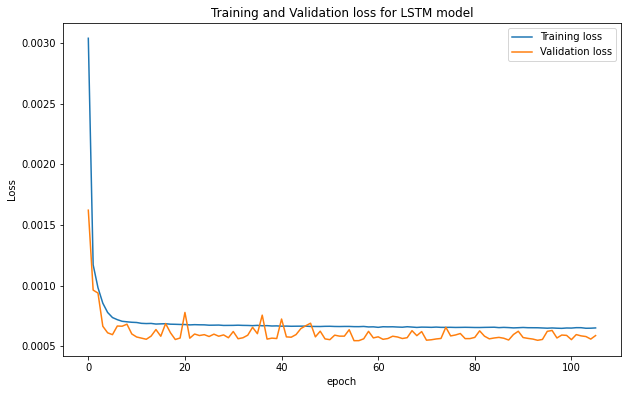

In [ ]:
# Visualization per season for trainning and validation data
import matplotlib.pyplot as plt

loss_by_epoch= history_pd['loss']
#val_loss_by_epoch= history_hypermodel_Trainning.history['val_loss']
val_loss_by_epoch= history_pd['val_loss']
plt.figure(figsize = (10, 6), dpi=72)
plt.title('Training and Validation loss for LSTM model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(loss_by_epoch)
plt.plot(val_loss_by_epoch)
plt.legend(['Training loss', 'Validation loss'], loc='best')

### 4.2.4 Load LSTM

In [ ]:
# Load LSTM if the files of weights (.h5) and architecture .json exist
import json
from tensorflow.keras.models import model_from_json

with open("hypermodel_LSTM_fit.json", "r") as m:
    model_json = m.read()

loaded_model_LSTM = model_from_json(model_json)
loaded_model_LSTM.summary()
loaded_model_LSTM.load_weights('LSTM/hypermodel_LSTM.weights.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 162)            │       106,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           163 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,307 (1.22 MB)

 Trainable params: 106,435 (415.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 212,872 (831.54 KB)

## 4.3 Prediction of SST

In [ ]:
# Load testing data
import pandas as pd

scaled_test_data = pd.read_csv("scaled_test_data.csv", index_col=0)  

# Extract input features (exclude last column)
test_X_scaled = scaled_test_data.iloc[:, :-1].values  
print("Shape of test_X_scaled before reshaping:", test_X_scaled.shape)
test_X_scaled = test_X_scaled.reshape(-1, window_lag_days, n_features)
print("Reshaped test_X_scaled:", test_X_scaled.shape)


# Extract target values if needed (last column)
test_y_scaled = scaled_test_data.iloc[:, -1].values  
print("Shape of test_y_scaled before reshaping:", test_y_scaled.shape)
test_y_scaled = test_y_scaled.reshape(-1, 1)  
print("Reshaped test_y_scaled:", test_y_scaled.shape)

# Predictions in testing data
scaled_predictions_y_Test_Data = loaded_model_LSTM.predict(test_X_scaled, batch_size=1)
print("Predictions completed!")

# Load predictions of the model
Real_y_prediction_on_Test= data_scaler.inverse_transform(scaled_predictions_y_Test_Data)

# Load real values of the data 
Inverted_y_from_Test = data_scaler.inverse_transform(test_y_scaled)

Shape of test_X_scaled before reshaping: (2219, 12)
Reshaped test_X_scaled: (2219, 12, 1)
Shape of test_y_scaled before reshaping: (2219,)
Reshaped test_y_scaled: (2219, 1)
2219/2219 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step
Predictions completed!


### 4.3.1 Results

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

mae= mean_absolute_error(Inverted_y_from_Test,Real_y_prediction_on_Test)
acc = ((1-(mae/Inverted_y_from_Test.mean()))*100)
mse = mean_squared_error(Inverted_y_from_Test,Real_y_prediction_on_Test)
rmse=sqrt(mse)
mape = mean_absolute_percentage_error(Inverted_y_from_Test,Real_y_prediction_on_Test)
r2 = r2_score(Inverted_y_from_Test,Real_y_prediction_on_Test)

print('Results in testing data:')
print('--------------------------')
print(f'RMSE: {round(rmse,3)} ')
print(f'ACC: {round(acc,3)} ')
print(f'MSE: {round(mse,3)} ')
print(f'MAE: {round(mae,3)} ')
print(f'MAPE: {round(mape,3)} ')
print(f'R^2: {round(r2,3)} ')

Results in testing data:
--------------------------
RMSE: 0.453 
ACC: 98.351 
MSE: 0.205 
MAE: 0.314 
MAPE: 0.016 
R^2: 0.989 


### 4.3.2 Actual and predicted comparisson

In [ ]:
plot_df = pd.DataFrame(index=test_data.index[window_lag_days:])
plot_df[["Actual"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Inverted_y_from_Test, columns=['TARGET'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])
plot_df[["Pred"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Real_y_prediction_on_Test, columns=['Pred'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])

for i in range(horizon):
      plot_df["Pred"+str(i+1)] = plot_df["Pred"+str(i+1)][:].shift(i)
      plot_df["Diff"+str(i+1)] = plot_df["Pred"+str(i+1)]-plot_df["Actual"+str(i+1)][:]
#plot_df.to_csv('LSTM/test-data-prediction-results-LSTM.csv')

### 4.3.3 Visualization of predictions

In [36]:
import scipy
corcoef, pval = scipy.stats.pearsonr(plot_df['Actual1'],plot_df['Pred1'])
print('Corcoef Value: ', corcoef)
print('Corcoef p-value:', pval)

Corcoef Value:  0.9945972288315053
Corcoef p-value: 0.0


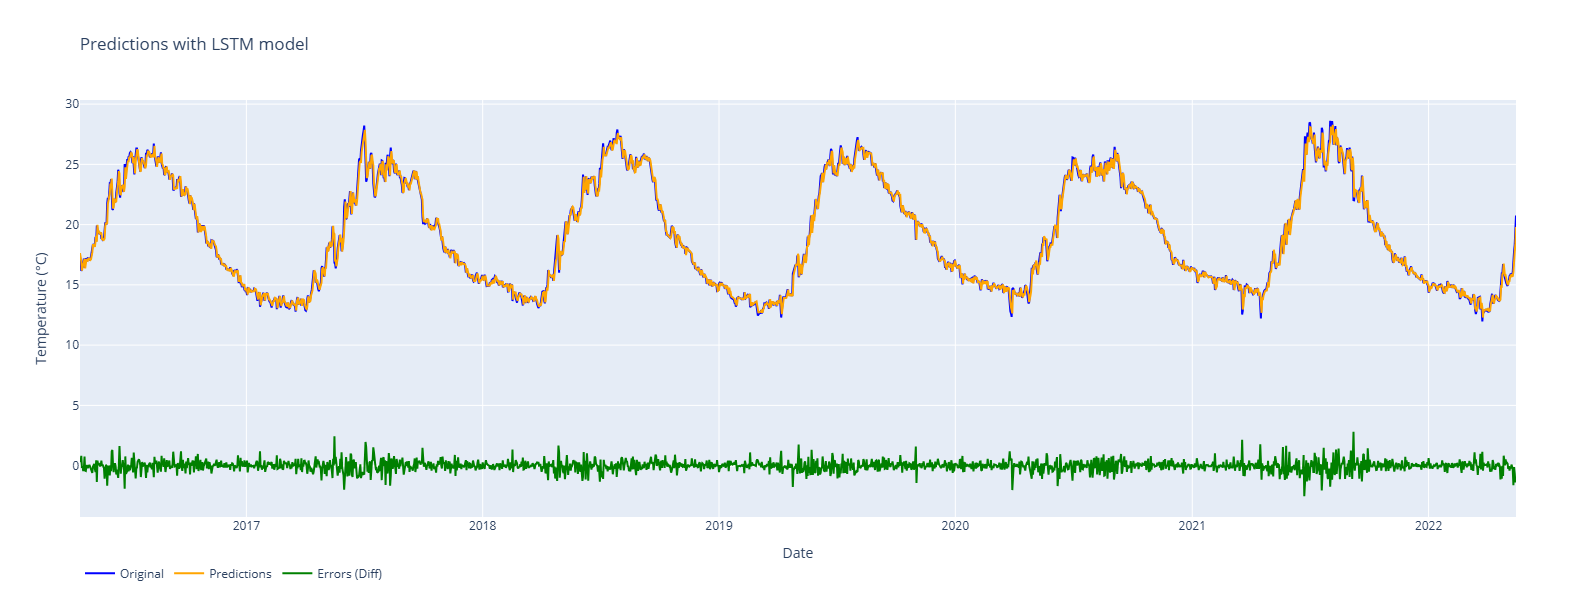

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Actual1'], line_color='blue', name='Original',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Pred1'], line_color='orange',name='Predictions',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Diff1'], line_color='green',name='Errors (Diff)',xhoverformat="%B %d, %Y"))

fig.update_layout(
    legend=dict(
    orientation="h"),
    autosize=True,
    height=600,
    title="Predictions with LSTM model",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    #template='plotly_white'
)

fig.show()

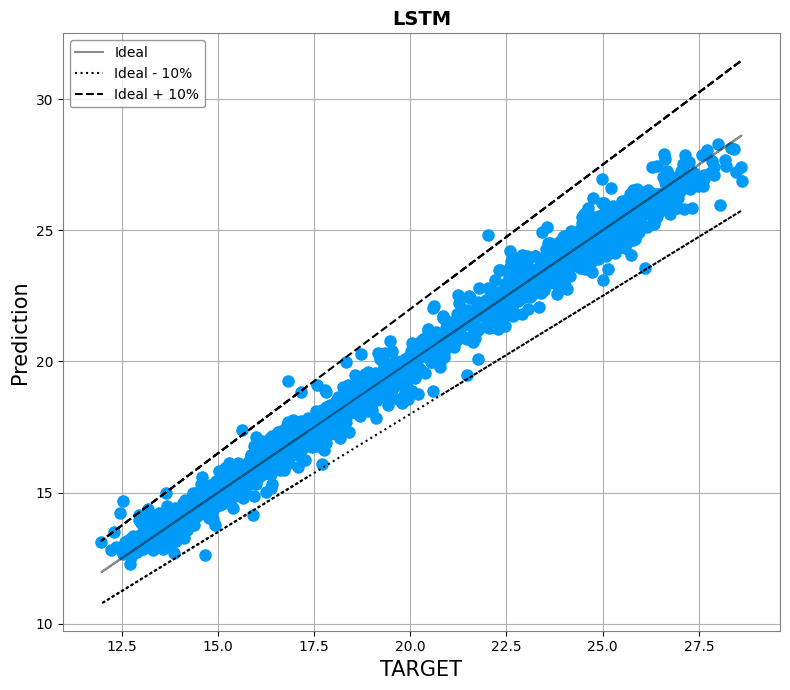

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

commutes = plot_df
#commutes = pd.read_csv('LSTM/test-data-prediction-results-LSTM.csv')

# Raw Data
target = np.array(commutes['Actual1']) #[-60:]
prediction = np.array(commutes['Pred1']) #[-60:]

fig, ax = plt.subplots(figsize=(8, 7), dpi=100)
x = target
y = prediction

ax.plot(x, y, "o", fillstyle='full', color="#009af9", markersize=8,
    markeredgewidth=1, #markeredgecolor="b", markerfacecolor="#4077b5"
)

x2 = x
y2 = x2
ax.plot(x2, y2, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Ideal")

ax.plot(x2, y2 - 0.1*y2, ":", color="black", label="Ideal - 10%")
ax.plot(x2, y2 + 0.1*y2, "--", color="black", label="Ideal + 10%")

# Figure Modifications
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out")
ax.get_yaxis().set_tick_params(direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Labels
plt.title("LSTM", fontsize="14", fontweight="bold")
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Prediction", fontsize=15)
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    
legend = plt.legend(
    [handle for i, handle in enumerate(handles)] + [anyArtist],
    [label for i, label in enumerate(labels)],
    #loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
)
frame = legend.get_frame().set_edgecolor("0.5")


# Save Figure
plt.tight_layout()
plt.grid()
#plt.savefig("filename.png", bbox_extra_artists=(legend,), bbox_inches="tight")
#plt.savefig("myimg.svg")
plt.show()


# 5. CNN implementation for SST prediction (3 kernel)

## 5.1 Definition of CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=190, kernel_size=3, activation='relu', input_shape=(window_lag_days, n_features)))
model_CNN.add(Flatten())
model_CNN.add(Dense(horizon))
model_CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss='mean_squared_error',
                        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

# Save CNN architecture
with open("model_CNN3_fit.json", "w") as m:
    m.write(model_CNN.to_json())

# Print Model Summary
model_CNN.summary()

/home/posuser/anaconda3/envs/poseidon_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 162)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1620)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269 (8.86 KB)

 Trainable params: 2,269 (8.86 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Plot CNN model
from keras.utils import plot_model
plot_model(model_CNN,
           #to_file='model_CNN.png',
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='LR',
           expand_nested=True,
           dpi=150,
           layer_range=None,
           show_layer_activations=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### 5.1.1 Trainning of CNN

In [ ]:
# Modelcheckpoint saves the best weights of the model
from keras.callbacks import ModelCheckpoint

Model_Checkpoint = ModelCheckpoint(filepath='CNN3/model_CNN.weights.h5',  
                                   monitor= 'val_rmse',
                                   save_weights_only=True,
                                   verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_rmse', patience=50, verbose=1)
history_Trainning_CNN = model_CNN.fit(batches_for_Train_Data,
                                                   epochs=300,
                                                   verbose=1,
                                                   callbacks=[Model_Checkpoint, stop_early],
                                                   shuffle=True, 
                                                   validation_data=(batches_for_Validation_Data))

Epoch 1/300
10352/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.0072 - rmse: 0.0731
Epoch 1: val_rmse improved from None to 0.03313, saving model to CNN3/model_CNN.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 7s 638us/step - loss: 0.0023 - rmse: 0.0484 - val_loss: 0.0011 - val_rmse: 0.0331
Epoch 2/300
10289/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 9.2148e-04 - rmse: 0.0303
Epoch 2: val_rmse improved from 0.03313 to 0.02782, saving model to CNN3/model_CNN.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 6s 609us/step - loss: 8.5965e-04 - rmse: 0.0293 - val_loss: 7.7374e-04 - val_rmse: 0.0278
Epoch 3/300
10348/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 7.8477e-04 - rmse: 0.0280
Epoch 3: val_rmse improved from 0.02782 to 0.02527, saving model to CNN3/model_CNN.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 6s 599us/step - loss: 7.7122e-04 - rmse: 0.0278 - val_loss: 6.3847e-04 - val_rmse: 0.0253
Epoch 4/300
10362/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 7.2270e-04 - rmse:

### 5.1.2 Save of CNN

In [ ]:
# Local save of entire model (all seasons)
model_CNN.export('CNN3/Model')
model_CNN.save('CNN3/Model.keras')
#model_CNN.save('CNN3/Model.h5')

INFO:tensorflow:Assets written to: CNN3/Model/assets


INFO:tensorflow:Assets written to: CNN3/Model/assets


Saved artifact at 'CNN3/Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name='keras_tensor_29')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  128715677482640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128715677481296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128715677482448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128715677469008: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [51]:
# Save of trainning history
import json
history_dict_CNN = history_Trainning_CNN.history
json.dump(history_dict_CNN, open('CNN3/model_CNN_History.json', 'w'))

history_dict_CNN = json.load(open('CNN3/model_CNN_History.json', 'r'))
history_pd_CNN = pd.DataFrame(history_dict_CNN)

### 5.1.3 Visualization of trainning losses

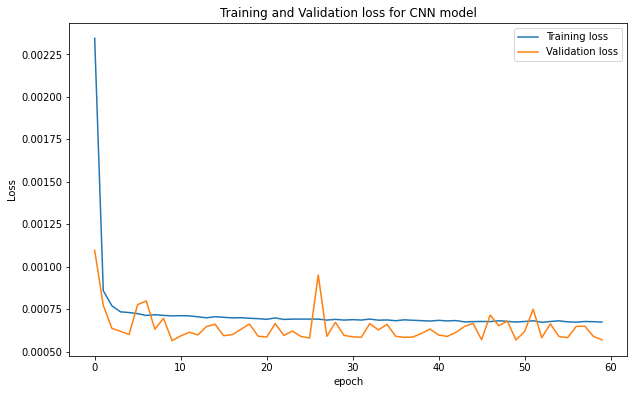

In [ ]:
# Visualization per season for trainning and validation data
import matplotlib.pyplot as plt
loss_by_epoch= history_pd_CNN['loss']
#val_loss_by_epoch= history_hypermodel_Trainning.history['val_loss']
val_loss_by_epoch= history_pd_CNN['val_loss']
plt.figure(figsize = (10, 6), dpi=72)
plt.title('Training and Validation loss for CNN model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(loss_by_epoch)
plt.plot(val_loss_by_epoch)
plt.legend(['Training loss', 'Validation loss'], loc='best')

### 5.1.3 Load of CNN

In [ ]:
# Load CNN if the files of weights (.h5) and architecture .json exist
import json
from tensorflow.keras.models import model_from_json

with open("model_CNN3_fit.json", "r") as m:
    model_json = m.read()

loaded_model_CNN = model_from_json(model_json)
loaded_model_CNN.summary()
loaded_model_CNN.load_weights('CNN3/model_CNN.weights.h5')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 162)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1620)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,809 (26.60 KB)

 Trainable params: 2,269 (8.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,540 (17.74 KB)

## 5.2 Prediction of SST

In [ ]:
import pandas as pd

scaled_test_data = pd.read_csv("scaled_test_data.csv", index_col=0)

# Extract input features (exclude last column)
test_X_scaled = scaled_test_data.iloc[:, :-1].values  
print("Shape of test_X_scaled before reshaping:", test_X_scaled.shape)
test_X_scaled = test_X_scaled.reshape(-1, window_lag_days, n_features)
print("Reshaped test_X_scaled:", test_X_scaled.shape)

# Extract target values if needed (last column)
test_y_scaled = scaled_test_data.iloc[:, -1].values  
print("Shape of test_y_scaled before reshaping:", test_y_scaled.shape)
test_y_scaled = test_y_scaled.reshape(-1, 1)  
print("Reshaped test_y_scaled:", test_y_scaled.shape)

# Predictions in testing data
scaled_predictions_y_Test_Data_CNN = loaded_model_CNN.predict(test_X_scaled, batch_size=1)
print("Predictions completed!")

# Load predictions of the model
Real_y_prediction_on_Test_CNN= data_scaler.inverse_transform(scaled_predictions_y_Test_Data_CNN)

# Load real values of the data 
Inverted_y_from_Test = data_scaler.inverse_transform(test_y_scaled)

Shape of test_X_scaled before reshaping: (2219, 12)
Reshaped test_X_scaled: (2219, 12, 1)
Shape of test_y_scaled before reshaping: (2219,)
Reshaped test_y_scaled: (2219, 1)
2219/2219 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step
Predictions completed!


### 5.2.1 Results

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

mae= mean_absolute_error(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)
acc = ((1-(mae/Inverted_y_from_Test.mean()))*100)
mse = mean_squared_error(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)
rmse=sqrt(mse)
mape = mean_absolute_percentage_error(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)
r2 = r2_score(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)

print('Results in testing data:')
print('--------------------------')
print(f'RMSE: {round(rmse,3)} ')
print(f'ACC: {round(acc,3)} ')
print(f'MSE: {round(mse,3)} ')
print(f'MAE: {round(mae,3)} ')
print(f'MAPE: {round(mape,3)} ')
print(f'R^2: {round(r2,3)} ')

Results in testing data:
--------------------------
RMSE: 0.459 
ACC: 98.318 
MSE: 0.211 
MAE: 0.32 
MAPE: 0.017 
R^2: 0.989 


### 5.2.2 Actual and predicted comparisson

In [56]:
plot_df = pd.DataFrame(index=test_data.index[window_lag_days:])
plot_df[["Actual"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Inverted_y_from_Test, columns=['TARGET'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])
plot_df[["Pred"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Real_y_prediction_on_Test_CNN, columns=['Pred'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])

for i in range(horizon):
      plot_df["Pred"+str(i+1)] = plot_df["Pred"+str(i+1)][:].shift(i)
      plot_df["Diff"+str(i+1)] = plot_df["Pred"+str(i+1)]-plot_df["Actual"+str(i+1)][:]
#plot_df.to_csv('CNN3/test-data-prediction-results-CNN.csv')

### 5.2.3 Visualization of predictions

In [57]:
import scipy
corcoef, pval = scipy.stats.pearsonr(plot_df['Actual1'],plot_df['Pred1'])
print('Corcoef Value: ', corcoef)
print('Corcoef p-value:', pval)

Corcoef Value:  0.9944414037672465
Corcoef p-value: 0.0


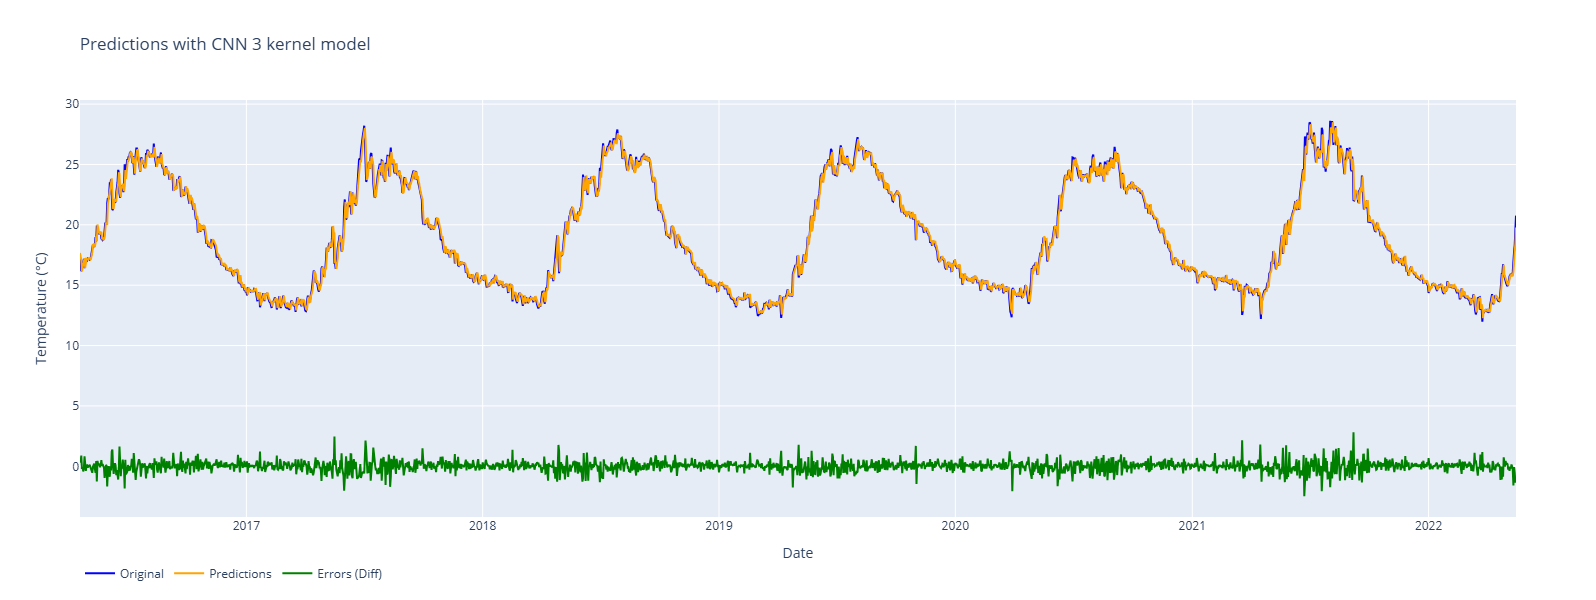

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Actual1'], line_color='blue', name='Original',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Pred1'], line_color='orange',name='Predictions',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Diff1'], line_color='green',name='Errors (Diff)',xhoverformat="%B %d, %Y"))

fig.update_layout(
    legend=dict(
    orientation="h"),
    autosize=True,
    height=600,
    title="Predictions with CNN 3 kernel model",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    #template='plotly_white'
)

fig.show()

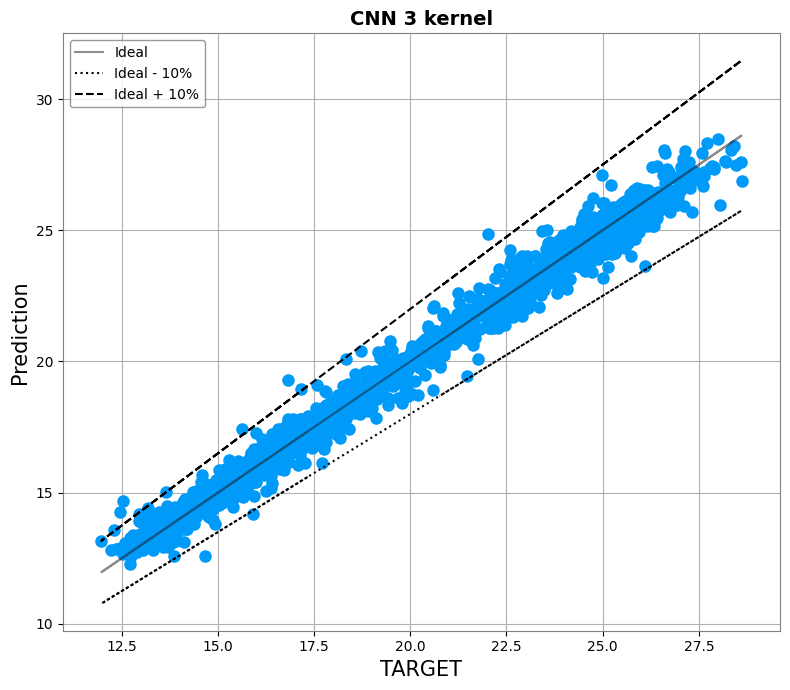

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

commutes = plot_df
#commutes = pd.read_csv('CNN3/test-data-prediction-results-CNN.csv')

# Raw Data
target = np.array(commutes['Actual1']) #[-60:]
prediction = np.array(commutes['Pred1']) #[-60:]

fig, ax = plt.subplots(figsize=(8, 7), dpi=100)

x = target
y = prediction

ax.plot(x, y, "o", fillstyle='full', color="#009af9", markersize=8,
    markeredgewidth=1, #markeredgecolor="b", markerfacecolor="#4077b5"
)

x2 = x
y2 = x2
ax.plot(x2, y2, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Ideal")

ax.plot(x2, y2 - 0.1*y2, ":", color="black", label="Ideal - 10%")
ax.plot(x2, y2 + 0.1*y2, "--", color="black", label="Ideal + 10%")

# Figure Modifications
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out")
ax.get_yaxis().set_tick_params(direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Labels
plt.title("CNN 3 kernel", fontsize="14", fontweight="bold")
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Prediction", fontsize=15)
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")   
legend = plt.legend(
    [handle for i, handle in enumerate(handles)] + [anyArtist],
    [label for i, label in enumerate(labels)],
    #loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
)
frame = legend.get_frame().set_edgecolor("0.5")


# Save Figure
plt.tight_layout()
plt.grid()
#plt.savefig("filename.png", bbox_extra_artists=(legend,), bbox_inches="tight")
#plt.savefig("myimg.svg")
plt.show()

# 6. CNN implementation for SST prediction (12 kernel)

## 6.1 Definition of CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=190, kernel_size=12, activation='relu', input_shape=(window_lag_days, n_features)))
model_CNN.add(Flatten())
model_CNN.add(Dense(horizon))
model_CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss='mean_squared_error',
                        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])
with open("model_CNN12_fit.json", "w") as m:
    m.write(model_CNN.to_json())

# Print Model Summary
model_CNN.summary()

/home/posuser/anaconda3/envs/poseidon_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1, 162)         │         2,106 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           163 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269 (8.86 KB)

 Trainable params: 2,269 (8.86 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Plot CNN model
from keras.utils import plot_model
plot_model(model_CNN,
           #to_file='model_CNN.png',
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='LR',
           expand_nested=True,
           dpi=150,
           layer_range=None,
           show_layer_activations=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### 6.1.1 Trainning of CNN

In [ ]:
# Modelcheckpoint saves the best weights of the model
from keras.callbacks import ModelCheckpoint

Model_Checkpoint = ModelCheckpoint(filepath='CNN12/model_CNN.weights.h5',  
                                   monitor= 'val_rmse',
                                   save_weights_only=True,
                                   verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_rmse', patience=50, verbose=1)
history_Trainning_CNN = model_CNN.fit(batches_for_Train_Data,
                                                   epochs=300,
                                                   verbose=1,
                                                   callbacks=[Model_Checkpoint, stop_early],
                                                   shuffle=True, 
                                                   validation_data=(batches_for_Validation_Data))

Epoch 1/300
10363/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.0102 - rmse: 0.0845
Epoch 1: val_rmse improved from None to 0.02843, saving model to CNN12/model_CNN.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 7s 631us/step - loss: 0.0027 - rmse: 0.0520 - val_loss: 8.0838e-04 - val_rmse: 0.0284
Epoch 2/300
10387/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 8.7036e-04 - rmse: 0.0295
Epoch 2: val_rmse improved from 0.02843 to 0.02781, saving model to CNN12/model_CNN.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 6s 576us/step - loss: 8.5756e-04 - rmse: 0.0293 - val_loss: 7.7358e-04 - val_rmse: 0.0278
Epoch 3/300
10348/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 8.3854e-04 - rmse: 0.0289
Epoch 3: val_rmse did not improve from 0.02781
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 6s 602us/step - loss: 8.0424e-04 - rmse: 0.0284 - val_loss: 9.4646e-04 - val_rmse: 0.0308
Epoch 4/300
10294/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 8.1623e-04 - rmse: 0.0286
Epoch 4: val_rmse did not improve

### 6.1.2 Save of CNN

In [ ]:
# Local save of entire model (all seasons)
model_CNN.export('CNN12/Model')
model_CNN.save('CNN12/Model.keras')
#model_CNN.save('CNN12/Model.h5')

INFO:tensorflow:Assets written to: CNN12/Model/assets


INFO:tensorflow:Assets written to: CNN12/Model/assets


Saved artifact at 'CNN12/Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name='keras_tensor_46')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  128713465435280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128713465436048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128713465430480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128713465437008: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [64]:
# Save of trainning history
import json

history_dict_CNN = history_Trainning_CNN.history
json.dump(history_dict_CNN, open('CNN12/model_CNN_History.json', 'w'))

history_dict_CNN = json.load(open('CNN12/model_CNN_History.json', 'r'))
history_pd_CNN = pd.DataFrame(history_dict_CNN)

### 6.1.3 Visualization of trainning losses

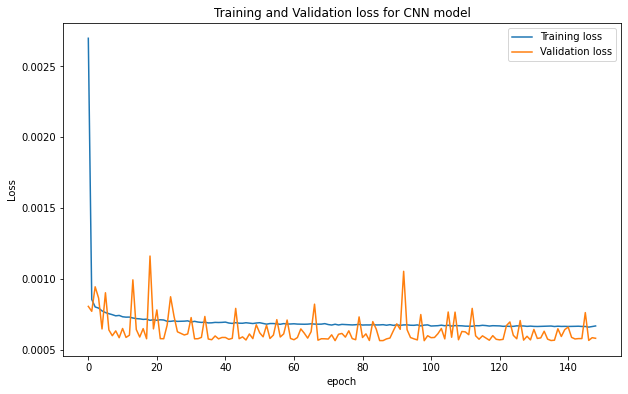

In [ ]:
# Visualization per season for trainning and validation data
import matplotlib.pyplot as plt
loss_by_epoch= history_pd_CNN['loss']
#val_loss_by_epoch= history_hypermodel_Trainning.history['val_loss']
val_loss_by_epoch= history_pd_CNN['val_loss']
plt.figure(figsize = (10, 6), dpi=72)
plt.title('Training and Validation loss for CNN model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(loss_by_epoch)
plt.plot(val_loss_by_epoch)
plt.legend(['Training loss', 'Validation loss'], loc='best')

### 6.1.4 Load of CNN

In [ ]:
# Load CNN if the files of weights (.h5) and architecture .json exist
import json
from tensorflow.keras.models import model_from_json

with open("model_CNN12_fit.json", "r") as m:
    model_json = m.read()

loaded_model_CNN = model_from_json(model_json)
loaded_model_CNN.summary()
loaded_model_CNN.load_weights('CNN12/model_CNN.weights.h5')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1, 162)         │         2,106 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           163 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,809 (26.60 KB)

 Trainable params: 2,269 (8.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,540 (17.74 KB)

## 6.2 Prediction of SST

In [ ]:
import pandas as pd

scaled_test_data = pd.read_csv("scaled_test_data.csv", index_col=0)  

# Extract input features (exclude last column)
test_X_scaled = scaled_test_data.iloc[:, :-1].values  
print("Shape of test_X_scaled before reshaping:", test_X_scaled.shape)
test_X_scaled = test_X_scaled.reshape(-1, window_lag_days, n_features)
print("Reshaped test_X_scaled:", test_X_scaled.shape)

# Extract target values if needed (last column)
test_y_scaled = scaled_test_data.iloc[:, -1].values 
print("Shape of test_y_scaled before reshaping:", test_y_scaled.shape)
test_y_scaled = test_y_scaled.reshape(-1, 1)  
print("Reshaped test_y_scaled:", test_y_scaled.shape)

scaled_predictions_y_Test_Data_CNN = loaded_model_CNN.predict(test_X_scaled, batch_size=1)
print("Predictions completed!")

Real_y_prediction_on_Test_CNN= data_scaler.inverse_transform(scaled_predictions_y_Test_Data_CNN)

Inverted_y_from_Test = data_scaler.inverse_transform(test_y_scaled)

Shape of test_X_scaled before reshaping: (2219, 12)
Reshaped test_X_scaled: (2219, 12, 1)
Shape of test_y_scaled before reshaping: (2219,)
Reshaped test_y_scaled: (2219, 1)
2219/2219 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step
Predictions completed!


### 6.2.1 Results

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

mae= mean_absolute_error(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)
acc = ((1-(mae/Inverted_y_from_Test.mean()))*100)
mse = mean_squared_error(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)
rmse=sqrt(mse)
mape = mean_absolute_percentage_error(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)
r2 = r2_score(Inverted_y_from_Test,Real_y_prediction_on_Test_CNN)

print('Results in testing data:')
print('--------------------------')
print(f'RMSE: {round(rmse,3)} ')
print(f'ACC: {round(acc,3)} ')
print(f'MSE: {round(mse,3)} ')
print(f'MAE: {round(mae,3)} ')
print(f'MAPE: {round(mape,3)} ')
print(f'R^2: {round(r2,3)} ')

Results in testing data:
--------------------------
RMSE: 0.46 
ACC: 98.326 
MSE: 0.211 
MAE: 0.319 
MAPE: 0.017 
R^2: 0.989 


### 6.2.2 Actual and predicted comparisson

In [69]:
plot_df = pd.DataFrame(index=test_data.index[window_lag_days:])
plot_df[["Actual"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Inverted_y_from_Test, columns=['TARGET'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])
plot_df[["Pred"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Real_y_prediction_on_Test_CNN, columns=['Pred'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])

for i in range(horizon):
      plot_df["Pred"+str(i+1)] = plot_df["Pred"+str(i+1)][:].shift(i)
      plot_df["Diff"+str(i+1)] = plot_df["Pred"+str(i+1)]-plot_df["Actual"+str(i+1)][:]
#plot_df.to_csv('CNN12/test-data-prediction-results-CNN.csv')

### 6.2.3 Visualization of predictions

In [70]:
import scipy
corcoef, pval = scipy.stats.pearsonr(plot_df['Actual1'],plot_df['Pred1'])
print('Corcoef Value: ', corcoef)
print('Corcoef p-value:', pval)

Corcoef Value:  0.9944414221072498
Corcoef p-value: 0.0


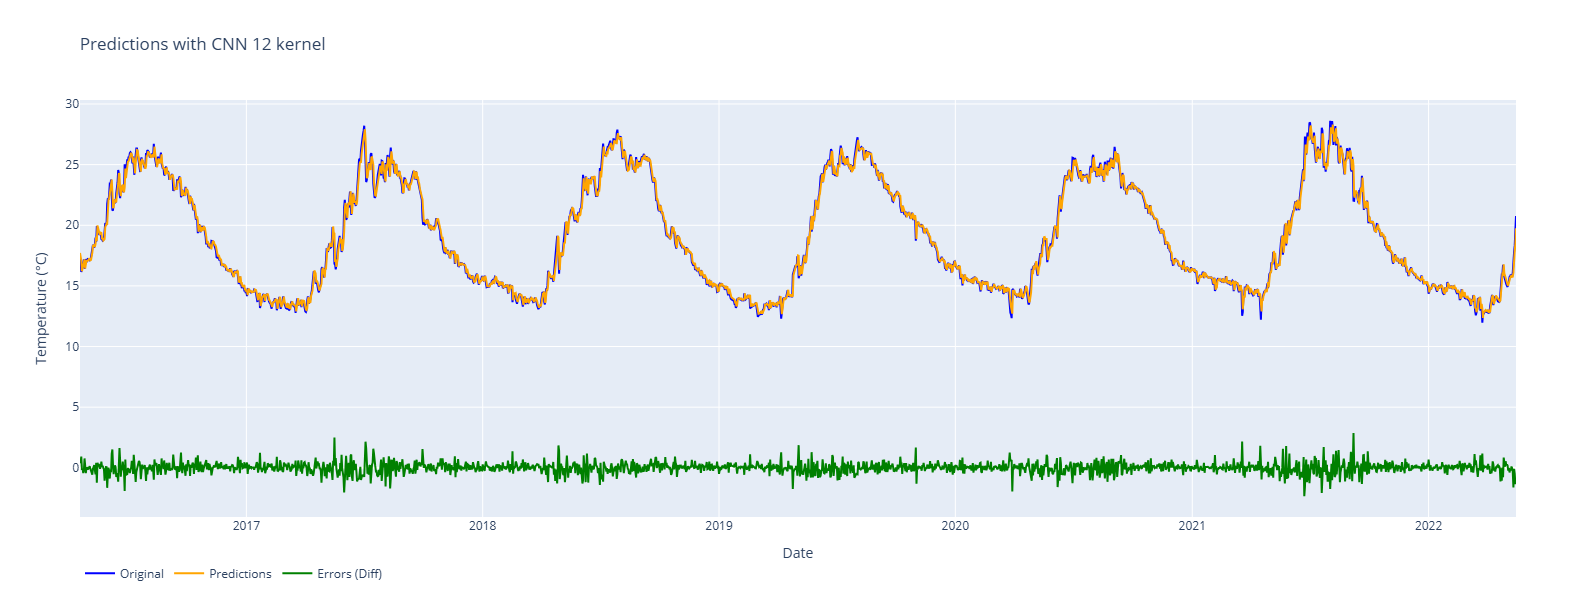

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Actual1'], line_color='blue', name='Original',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Pred1'], line_color='orange',name='Predictions',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Diff1'], line_color='green',name='Errors (Diff)',xhoverformat="%B %d, %Y"))

fig.update_layout(
    legend=dict(
    orientation="h"),
    autosize=True,
    height=600,
    title="Predictions with CNN 12 kernel",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    #template='plotly_white'
)

fig.show()

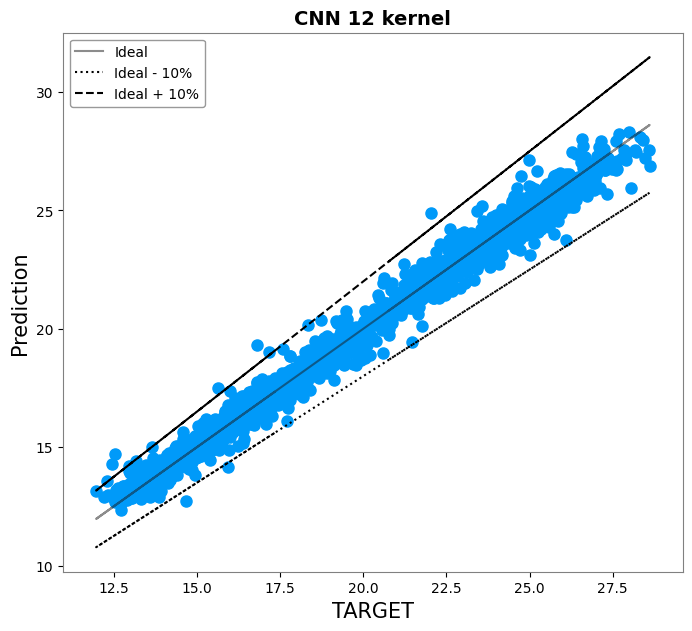

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

commutes = plot_df
#commutes = pd.read_csv('CNN12/test-data-prediction-results-CNN.csv'')

target = np.array(commutes['Actual1']) #[-60:]
prediction = np.array(commutes['Pred1']) #[-60:]

fig, ax = plt.subplots(figsize=(8, 7), dpi=100)

x = target
y = prediction

ax.plot(x, y, "o", fillstyle='full', color="#009af9", markersize=8,
    markeredgewidth=1, #markeredgecolor="b", markerfacecolor="#4077b5"
)

x2 = x
y2 = x2
ax.plot(x2, y2, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Ideal")

ax.plot(x2, y2 - 0.1*y2, ":", color="black", label="Ideal - 10%")
ax.plot(x2, y2 + 0.1*y2, "--", color="black", label="Ideal + 10%")

# Figure Modifications
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out")
ax.get_yaxis().set_tick_params(direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Labels
plt.title("CNN 12 kernel", fontsize="14", fontweight="bold")
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Prediction", fontsize=15)
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")   
legend = plt.legend(
    [handle for i, handle in enumerate(handles)] + [anyArtist],
    [label for i, label in enumerate(labels)],
    #loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
)
frame = legend.get_frame().set_edgecolor("0.5")

# 7. Comparissons

| **Model**                          | **Layer**                  | **Input Shape**        | **Output Shape**       | **Explanation**                                                                                     | **Visual Representation**                                                             |
|------------------------------------|----------------------------|------------------------|------------------------|-----------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| **LSTM**                           | Input                      | (None, 12, 1)          | (None, 12, 1)          | Sequences of 12 days with 1 feature (SST) are fed into the LSTM.                                     | 📈 ➔ [SST₁, SST₂, ..., SST₁₂]                                                         |
|                                    | LSTM (190 units)           | (None, 12, 1)          | (None, 190)            | LSTM processes temporal dependencies and outputs a 190-dimensional vector.                          | 🔄 Memory cells capturing time dependencies ➔ 🔗 Vector (190)                          |
|                                    | Dense (horizon=1)          | (None, 190)            | (None, 1)              | Fully connected layer reduces to a single predicted SST value.                                       | 🔗 Vector ➔ 🎯 SST₁₃                                                                   |
| **CNN (`kernel_size=3`)**          | Input                      | (None, 12, 1)          | (None, 12, 1)          | 12-day SST sequences are passed to the Conv1D layer.                                                 | 📈 ➔ [SST₁, SST₂, ..., SST₁₂]                                                         |
|                                    | Conv1D (190 filters)       | (None, 12, 1)          | (None, 10, 190)        | Conv1D slides 3-length filters, extracting local patterns over time.                                 | 🎛️ Filters ➔ 📊 Feature maps                                                         |
|                                    | Flatten                    | (None, 10, 190)        | (None, 1900)           | Converts the 3D tensor to 2D for Dense layer input.                                                  | 📊 Flatten ➔ 📏 Vector (1900)  -  Output Length=Input Length - **Kernel Size** + 1 = 12 - 3 + 1 = 10 =Flatten layer converts (None, 10, 190) into (None, 10 × 190) = (None, 1900)                                                      |
|                                    | Dense (horizon=1)          | (None, 1900)           | (None, 1)              | Outputs a single SST prediction.                                                                    | 📏 Vector ➔ 🎯 SST₁₃                                                                   |
| **CNN (`kernel_size=12`)**         | Input                      | (None, 12, 1)          | (None, 12, 1)          | Similar input structure as above.                                                                   | 📈 ➔ [SST₁, SST₂, ..., SST₁₂]                                                         |
|                                    | Conv1D (190 filters)       | (None, 12, 1)          | (None, 1, 190)         | Kernel size covers the entire 12-day window, learning global temporal features.                     | 🌐 Global filter ➔ 📊 Feature maps                                                   |
|                                    | Flatten                    | (None, 1, 190)         | (None, 190)            | Flattens the feature map for Dense layer processing.                                                 | 📊 Flatten ➔ 📏 Vector (190)                                                         |
|                                    | Dense (horizon=1)          | (None, 190)            | (None, 1)              | Final SST prediction output.                                                                        | 📏 Vector ➔ 🎯 SST₁₃                                                                   |


Note that some of the comparissons at the previous cell reffer to units = 190, this might change depending of the outcomes of Hyperband.

Explanation of None in Shapes:

In TensorFlow/Keras, None in a shape represents a flexible batch size. It means that the model can process any number of samples in a batch during training or inference.

For example:

(None, 12, 1) → The model can process batches of sequences, where:

*   None: Any number of samples in a batch (e.g., 32, 64, etc.).
*   12: 12 time steps (days) as input.
*   1: One feature per time step (SST in this case).



